# Analysis Report
For the Trust Stamp assessment.

Candidate: Pablo Martínez-Agulló

Hanut, an online retailer, wants to enhance customer experiences by personalizing them based on age demographics. After exploring image-based age estimation solutions, they have shortlisted two models and are seeking our analysis to determine which model to adopt. Their consumer age profiles are segmented into specific brackets: 0-12, 13-15, 16-17, 18-24, 25-30, 31-40, 41-50, 51-60, 61-70, 71-80, and 81+.

The two shortlisted models are:

- **Model 1**
  - Predicts an age range, given as `age_min` and `age_max`.
  - Data available in `data/model_1.csv`, containing 6975 entries.
  
- **Model 2**
  - Provides a direct age prediction labeled as `age`.
  - Data available in `data/model_2.csv`, containing 6969 entries.

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the CSV files into DataFrames
model_1 = pd.read_csv('data/model_1.csv')
model_2 = pd.read_csv('data/model_2.csv')
true_labels = pd.read_csv('data/gt.csv')

# Rename the 'path' column to 'file_name' in model_2 and sort
model_2 = model_2.rename(columns={'path': 'file_name'})
model_1 = model_1.sort_values(by='file_name', ascending=True)
model_2 = model_2.sort_values(by='file_name', ascending=True)
true_labels = true_labels.sort_values(by='file_name', ascending=True)

print(f"Size of model_1 DataFrame: {model_1.shape} (rows, columns)")
print(f"Size of model_2 DataFrame: {model_2.shape} (rows, columns)")
print(f"Size of true_labels DataFrame: {true_labels.shape} (rows, columns)")

# Display the first few rows of each DataFrame to verify successful loading
print("Model 1 DataFrame:")
print(model_1.head())

print("\nModel 2 DataFrame:")
print(model_2.head())

print("\nTrue Labels DataFrame:")
print(true_labels.head())

Size of model_1 DataFrame: (6975, 5) (rows, columns)
Size of model_2 DataFrame: (6969, 4) (rows, columns)
Size of true_labels DataFrame: (8644, 3) (rows, columns)
Model 1 DataFrame:
      Unnamed: 0  index   file_name  age_min  age_max
4809        4809   5221  000000.jpg      1.0      7.0
862          862    906  000001.jpg     16.0     22.0
3690        3690   3963  000002.jpg     72.0     80.0
294          294    305  000003.jpg     51.0     59.0
3869        3869   4161  000004.jpg     13.0     21.0

Model 2 DataFrame:
   Unnamed: 0  index   file_name   age
0           0      0  000000.jpg   6.0
1           1      1  000001.jpg  25.0
2           2      2  000002.jpg  69.0
3           3      3  000003.jpg  50.0
4           4      4  000004.jpg  16.0

True Labels DataFrame:
      Unnamed: 0   file_name  real_age
5221        5221  000000.jpg         4
906          906  000001.jpg        18
3963        3963  000002.jpg        80
305          305  000003.jpg        50
4161        4161  000

Comparing entries of the diferent dataframes. 

In [239]:
# Check if every 'file_name' in model_1 or model_2 is present in true_labels
missing_in_true_labels1 = ~model_1['file_name'].isin(true_labels['file_name'])
missing_in_true_labels2 = ~model_1['file_name'].isin(true_labels['file_name'])


if missing_in_true_labels1.any():
    print("There are 'file_name' entries in model_1 that are missing in true_labels:")
    print(model_1[missing_in_true_labels1]['file_name'])
else:
    print("All 'file_name' entries in model_1 have corresponding entries in true_labels.")
    
# Display the result
if missing_in_true_labels2.any():
    print("There are 'file_name' entries in model_2 that are missing in true_labels:")
    print(model_2[missing_in_true_labels2]['file_name'])
else:
    print("All 'file_name' entries in model_2 have corresponding entries in true_labels.")

All 'file_name' entries in model_1 have corresponding entries in true_labels.
All 'file_name' entries in model_2 have corresponding entries in true_labels.


In [240]:
# Check if 'file_name' matches across the DataFrames
file_name_match_1_2 = model_1_sorted['file_name'].equals(model_2_sorted['file_name'])
file_name_match_1_true = model_1_sorted['file_name'].equals(true_labels_sorted['file_name'])
file_name_match_2_true = model_2_sorted['file_name'].equals(true_labels_sorted['file_name'])

# Print results
if False:
    print(f"Do 'file_name' entries match between model_1 and model_2? {file_name_match_1_2}")
    print(f"Do 'file_name' entries match between model_1 and true_labels? {file_name_match_1_true}")
    print(f"Do 'file_name' entries match between model_2 and true_labels? {file_name_match_2_true}")

Both models' datasets contain some missing entries when compared to the ground truth data. In the following cell, we merge the three datasets and remove the rows with empty values.

In [241]:
# Merge the DataFrames based on 'file_name'
merged_df = pd.merge(true_labels[['file_name', 'real_age']], 
                     model_1[['file_name', 'age_min', 'age_max']], 
                     on='file_name', how='inner')

merged_df = pd.merge(merged_df, 
                     model_2[['file_name', 'age']], 
                     on='file_name', how='inner')

# Rename columns for clarity
merged_df = merged_df.rename(columns={
    'age_min': 'model_1_age_min',
    'age_max': 'model_1_age_max',
    'age': 'model_2_age'
})

merged_df['model_1_age_avg'] = (merged_df['model_1_age_min'] + merged_df['model_1_age_max']) / 2
merged_df['model_1_age_error'] = merged_df['model_1_age_max'] - merged_df['model_1_age_min']


print(f"Number of null values: {merged_df.isnull().sum()} ")

if True: # Drop NaN
    merged_df = merged_df.dropna(subset=['real_age', 'model_1_age_avg', 'model_1_age_error', 'model_2_age'])

# Display the merged DataFrame
print(merged_df.head())

Number of null values: file_name            0
real_age             0
model_1_age_min      3
model_1_age_max      5
model_2_age          4
model_1_age_avg      8
model_1_age_error    8
dtype: int64 
    file_name  real_age  model_1_age_min  model_1_age_max  model_2_age  \
0  000000.jpg         4              1.0              7.0          6.0   
1  000001.jpg        18             16.0             22.0         25.0   
2  000002.jpg        80             72.0             80.0         69.0   
3  000003.jpg        50             51.0             59.0         50.0   
4  000004.jpg        17             13.0             21.0         16.0   

   model_1_age_avg  model_1_age_error  
0              4.0                6.0  
1             19.0                6.0  
2             76.0                8.0  
3             55.0                8.0  
4             17.0                8.0  


The dataframe for the comparison has 6957 complete entries and 7 columns.

In [242]:
# Check data types
print(merged_df.dtypes)
print(f"Dimensions: {merged_df.shape}")

file_name             object
real_age               int64
model_1_age_min      float64
model_1_age_max      float64
model_2_age          float64
model_1_age_avg      float64
model_1_age_error    float64
dtype: object
Dimensions: (6957, 7)


In [259]:
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6957 entries, 0 to 6968
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   file_name            6957 non-null   object  
 1   real_age             6957 non-null   int64   
 2   model_1_age_min      6957 non-null   float64 
 3   model_1_age_max      6957 non-null   float64 
 4   model_2_age          6957 non-null   float64 
 5   model_1_age_avg      6957 non-null   float64 
 6   model_1_age_error    6957 non-null   float64 
 7   real_age_bin         6957 non-null   category
 8   model_2_age_bin      6957 non-null   category
 9   model_1_age_avg_bin  6957 non-null   category
dtypes: category(3), float64(5), int64(1), object(1)
memory usage: 456.3+ KB


We can observe the main characteristics of the dataset. 

| Metric  | real_age   | model_1_age_min | model_1_age_max | model_2_age  | model_1_age_avg | model_1_age_error |
|---------|------------|-----------------|-----------------|--------------|-----------------|-------------------|
| mean   | 31.248095   | 27.082076       | 34.397298       | 30.985482    | 30.739687       | 7.315222          |

The mean of the model_2_age is closer to the real_age than model_1_age_avg



In [244]:
merged_df.describe()

,real_age,model_1_age_min,model_1_age_max,model_2_age,model_1_age_avg,model_1_age_error
count,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000,6957.000000
mean,31.248095,27.082076,34.397298,30.985482,30.739687,7.315222
std,17.011843,15.255285,16.079043,14.258627,15.656785,1.406759
min,1.000000,0.000000,2.000000,1.000000,1.000000,2.000000
25%,20.000000,19.000000,23.000000,25.000000,21.000000,8.000000
50%,29.000000,24.000000,32.000000,28.000000,28.000000,8.000000
75%,41.000000,35.000000,43.000000,37.000000,39.000000,8.000000
max,100.000000,85.000000,93.000000,83.000000,89.000000,10.000000


Since we have upper and lower margins for the Model 1 prediction, we can plot the errors bars. 

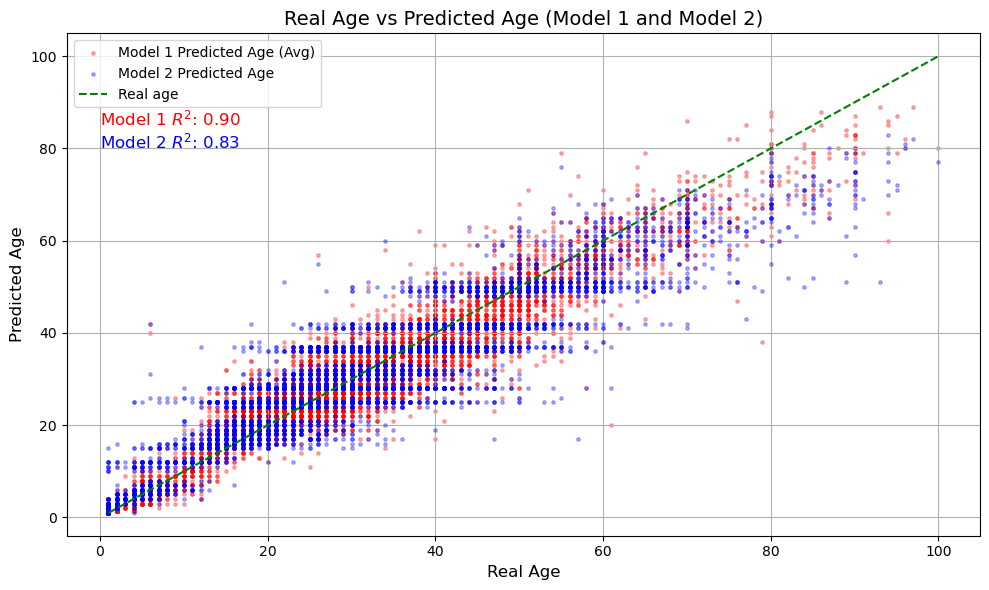

In [267]:
from sklearn.metrics import r2_score

# Calculate R^2 for Model 1 and Model 2
r2_model_1 = r2_score(merged_df['real_age'], merged_df['model_1_age_avg'])
r2_model_2 = r2_score(merged_df['real_age'], merged_df['model_2_age'])

# Create the scatter plot
plt.figure(figsize=(10, 6))


plot_errorbar = False
if plot_errorbar:
    # Plot model_1 predicted ages (average of min and max) with error bars
    plt.errorbar(merged_df['real_age'], merged_df['model_1_age_avg'], 
                 yerr=merged_df['model_1_age_error'] / 2, fmt='o', 
                 color='red', label='Model 1 Predicted Age (Avg)', 
                 ecolor='lightgray', elinewidth=2, capsize=4, zorder=1, alpha=0.2)
else:
    plt.scatter(merged_df['real_age'], merged_df['model_1_age_avg'], 
                color='red', label='Model 1 Predicted Age (Avg)', zorder=1, alpha=0.3, s=6)

# Plot model_2 predicted ages
plt.scatter(merged_df['real_age'], merged_df['model_2_age'], 
            color='blue', label='Model 2 Predicted Age', zorder=2, alpha=0.3, s=6)


# Add a line y = x for reference
plt.plot([merged_df['real_age'].min(), merged_df['real_age'].max()], 
         [merged_df['real_age'].min(), merged_df['real_age'].max()], 
         color='green', linestyle='--', label='Real age', zorder=3)

# Display the R^2 coefficients on the plot
plt.text(0, 85, f'Model 1 $R^2$: {r2_model_1:.2f}', color='red', fontsize=12)
plt.text(0, 80, f'Model 2 $R^2$: {r2_model_2:.2f}', color='blue', fontsize=12)



# Set plot labels and title
plt.xlabel('Real Age', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('Real Age vs Predicted Age (Model 1 and Model 2)', fontsize=14)

# Show the legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid()
plt.show()



The above figure is not very useful for deciding which model is better. Although we can see that as the real age increases, both models tend to underestimate it.

The horizontal alignment of points for Model 2 indicates that its predictions might be discretized to specific values, instead of providing more granular continuous predictions. These lines may also be causing the lower $R^2$ score of Model 2.

In [246]:
# Apply age brackets

# Define the age brackets
bins = [0, 12.99, 15.99, 17.99, 24.99, 30.99, 40.99, 50.99, 60.99, 70.99, 80.99, 100.99]
bin_labels = ['0-12', '13-15', '16-17', '18-24', '25-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']

# Bin the real ages (X-axis) and the predicted ages (Y-axis)
merged_df['real_age_bin'] = pd.cut(merged_df['real_age'], bins=bins, labels=bin_labels, right=False)
merged_df['model_2_age_bin'] = pd.cut(merged_df['model_2_age'], bins=bins, labels=bin_labels, right=False)
merged_df['model_1_age_avg_bin'] = pd.cut(merged_df['model_1_age_avg'], bins=bins, labels=bin_labels, right=False)

# Create the scatter plot
#plt.figure(figsize=(10, 6))

#plt.errorbar(merged_df['real_age_bin'], merged_df['model_1_age_avg_bin'], 
#             yerr=merged_df['model_1_age_error'] / 2, fmt='o', 
#             color='red', label='Model 1 Predicted Age (Avg)', 
#             ecolor='lightgray', elinewidth=2, capsize=4, zorder=2)

#plt.scatter(merged_df['real_age_bin'], merged_df['model_1_age_avg_bin'], color='red', label='Model 1 Predicted Age', zorder=1)
#plt.scatter(merged_df['real_age_bin'], merged_df['model_2_age_bin'], color='blue', label='Model 2 Predicted Age', zorder=2)
#plt.plot(bin_labels, bin_labels, color='green', linestyle='--', label='Real age', zorder=3)
#plt.plot(bin_labels, bin_labels, color='green', linestyle='--', label='Real age', zorder=3)

#plt.xlabel('Real Age (Binned)', fontsize=12)
#plt.ylabel('Predicted Age (Binned)', fontsize=12)
#plt.title('Real Age vs Binned Predicted Age', fontsize=14)

#plt.legend()
#plt.tight_layout()
#plt.show()

Bar plot with grouped bars for each age bracket.

Group by real_age_bin column. For each age bin, it calculates the mean value model_1_age_avg (average predicted age from Model 1) and model_2_age (predicted age from Model 2).


/var/folders/_y/4xrm6t5x0y748k3kh09fhwj80000gn/T/ipykernel_78305/2019906191.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = merged_df.groupby('real_age_bin').agg({


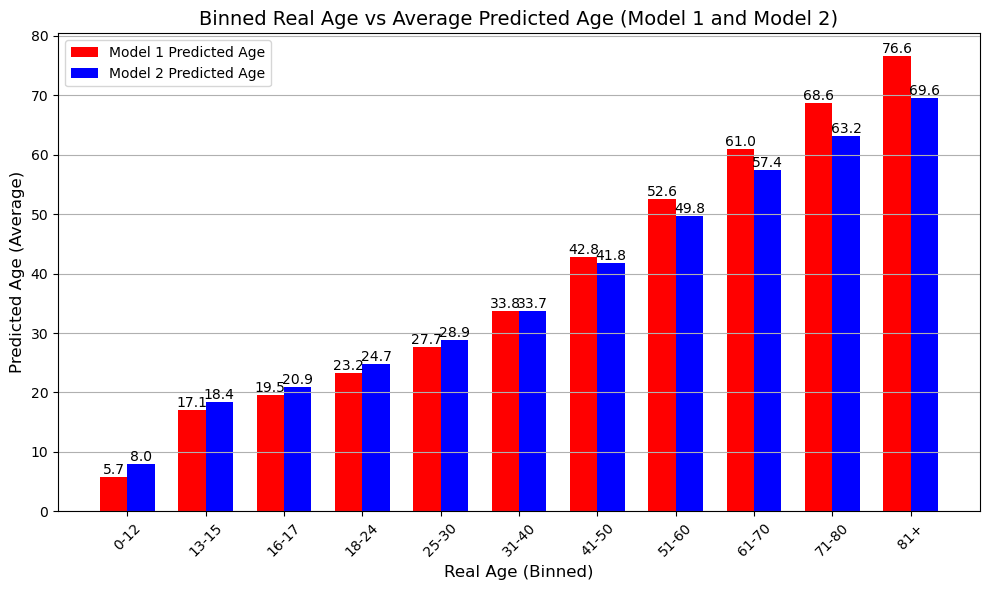

In [258]:
# Calculate the mean predicted age for each bin
grouped = merged_df.groupby('real_age_bin').agg({
    'model_1_age_avg': 'mean',
    'model_2_age': 'mean'
}).reset_index()

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(grouped['real_age_bin']))

# Create the bars for Model 1 and Model 2 predicted ages
bars1 = plt.bar(index, grouped['model_1_age_avg'], bar_width, color='red', label='Model 1 Predicted Age')
bars2 = plt.bar(index + bar_width, grouped['model_2_age'], bar_width, color='blue', label='Model 2 Predicted Age')

# Add annotations (the actual Y-value) on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', fontsize=10)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', fontsize=10)

# Set labels, title, and ticks
plt.xlabel('Real Age (Binned)', fontsize=12)
plt.ylabel('Predicted Age (Average)', fontsize=12)
plt.xticks(index + bar_width / 2, grouped['real_age_bin'], rotation=45)
plt.title('Binned Real Age vs Average Predicted Age (Model 1 and Model 2)', fontsize=14)

plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

Box plot showing the distribution of the predicted ages for each real age bracket. 

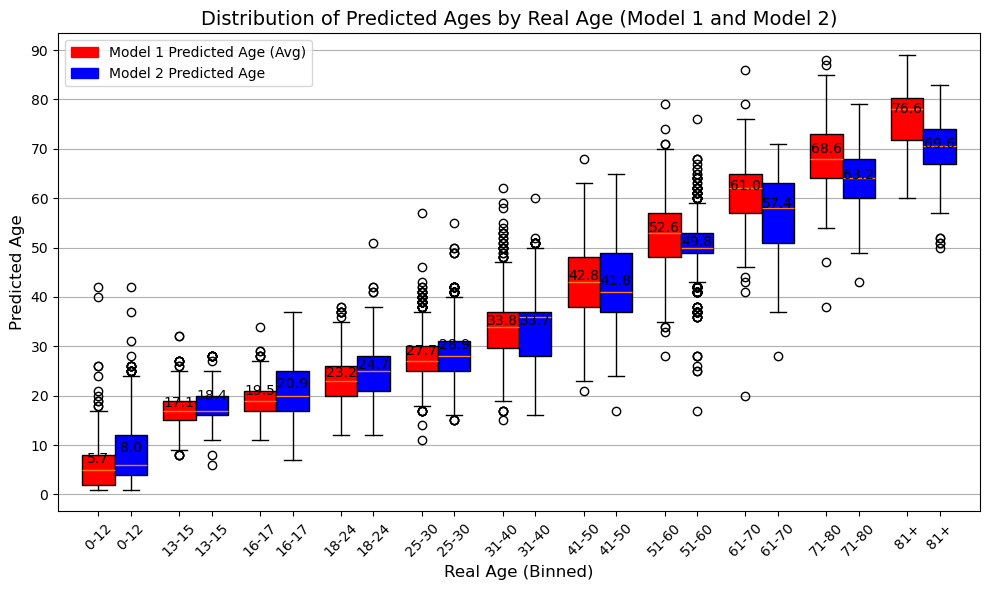

In [257]:
import matplotlib.patches as mpatches


plt.figure(figsize=(10, 6))

# Plot the boxplots for model_1_age_avg and model_2_age
box1 = plt.boxplot([merged_df[merged_df['real_age_bin'] == age_bin]['model_1_age_avg'] for age_bin in bin_labels],
                   positions=np.arange(len(bin_labels)) - 0.2, widths=0.4, patch_artist=True, 
                   boxprops=dict(facecolor='red'), labels=bin_labels)

box2 = plt.boxplot([merged_df[merged_df['real_age_bin'] == age_bin]['model_2_age'] for age_bin in bin_labels],
                   positions=np.arange(len(bin_labels)) + 0.2, widths=0.4, patch_artist=True, 
                   boxprops=dict(facecolor='blue'), labels=bin_labels)

# Calculate and annotate the average value for each boxplot (Model 1)
for i, age_bin in enumerate(bin_labels):
    model_1_mean = merged_df[merged_df['real_age_bin'] == age_bin]['model_1_age_avg'].mean()
    plt.text(i - 0.2, model_1_mean, f'{model_1_mean:.1f}', ha='center', va='bottom', fontsize=10, color='black')

# Calculate and annotate the average value for each boxplot (Model 2)
for i, age_bin in enumerate(bin_labels):
    model_2_mean = merged_df[merged_df['real_age_bin'] == age_bin]['model_2_age'].mean()
    plt.text(i + 0.2, model_2_mean, f'{model_2_mean:.1f}', ha='center', va='bottom', fontsize=10, color='black')

# Set plot labels and title
plt.xlabel('Real Age (Binned)', fontsize=12)
plt.ylabel('Predicted Age', fontsize=12)
plt.title('Distribution of Predicted Ages by Real Age (Model 1 and Model 2)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Create custom legend patches
red_patch = mpatches.Patch(color='red', label='Model 1 Predicted Age (Avg)')
blue_patch = mpatches.Patch(color='blue', label='Model 2 Predicted Age')

plt.legend(handles=[red_patch, blue_patch], loc='upper left')

# Adjust the y-ticks to create double marks
y_min, y_max = plt.ylim()  # Get current y-axis limits
y_ticks = np.arange(0, y_max + 1, 10)  
#y_minor_ticks = np.arange(y_min, y_max + 1, 2.5)  # Minor ticks every 2.5 units

plt.yticks(y_ticks)  # Set major ticks
#plt.minorticks_on()  # Enable minor ticks
#plt.gca().set_yticks(y_minor_ticks, minor=True)  # Set minor ticks

plt.tight_layout()
plt.grid(axis='y', which='both')


plt.show()

By observing the bar and box plots, one can see that Model 1 perdorms better


| Age Bin | Model 1 | Model 2 |
|---------|---------|---------|
| 0-12    | Good    | Good    |
| 13-15   | Bad     | Bad     |
| 16-17   | Bad     | Bad     |
| 18-24   | Good    | Good    |
| 25-30   | Good    | Good    |
| 31-40   | Good    | Good    |
| 41-50   | Good    | God     |
| 51-60   | Good    | Bad     |
| 61-70   | Good    | Bad     |
| 71-80   | Bad     | Bad     |
| 81+     | Bad     | Bad     |


On the following cells we compute the average absolute discrepancy between the real_age and the predictions from both model_1_age_avg and model_2_age, first overall and then for each age bracket.

In [211]:
# Bin the real ages into age brackets
merged_df['age_bracket'] = pd.cut(merged_df['real_age'], bins=bins, labels=bin_labels, right=False)


In [212]:
merged_df[['real_age','model_1_age_avg','model_2_age','age_bracket']]


,real_age,model_1_age_avg,model_2_age,age_bracket
0,4,4.0,6.0,0-12
1,18,19.0,25.0,18-24
2,80,76.0,69.0,71-80
3,50,55.0,50.0,41-50
4,17,17.0,16.0,16-17
...,...,...,...,...
6964,10,12.0,12.0,0-12
6965,37,42.0,42.0,31-40
6966,28,28.0,31.0,25-30
6967,20,24.0,32.0,18-24


In [213]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [214]:
# Average total
# Calculate MSE and MAPE

mse_model_1 = np.mean((merged_df['real_age'] - merged_df['model_1_age_avg']) ** 2)
mape_model_1 = mean_absolute_percentage_error(merged_df['real_age'], merged_df['model_1_age_avg'])

mse_model_2 = np.mean((merged_df['real_age'] - merged_df['model_2_age']) ** 2)
mape_model_2 = mean_absolute_percentage_error(merged_df['real_age'], merged_df['model_2_age'])


print(f"Model 1 - Mean Squared Error: {mse_model_1:.2f}, Mean Absolute Percentage Error: {mape_model_1:.2f}%")
print(f"Model 2 - Mean Squared Error: {mse_model_2:.2f}, Mean Absolute Percentage Error: {mape_model_2:.2f}%")


Model 1 - Mean Squared Error: 29.87, Mean Absolute Percentage Error: 16.08%
Model 2 - Mean Squared Error: 48.40, Mean Absolute Percentage Error: 24.31%


In [215]:
# average by age brackets 

discrepancy_1 = merged_df.groupby('age_bracket').apply(lambda x: np.mean(np.abs(x['real_age'] - x['model_1_age_avg'])))
discrepancy_2 = merged_df.groupby('age_bracket').apply(lambda x: np.mean(np.abs(x['real_age'] - x['model_2_age'])))

discrepancy_df = pd.DataFrame({
    'Average Discrepancy (Model 1)': discrepancy_1,
    'Average Discrepancy (Model 2)': discrepancy_2
})

print("\nAverage Absolute Discrepancy by Age Bracket:")
print(discrepancy_df)


Average Absolute Discrepancy by Age Bracket:
             Average Discrepancy (Model 1)  Average Discrepancy (Model 2)
age_bracket                                                              
0-12                              1.677778                       3.125000
13-15                             3.629508                       4.573770
16-17                             3.471299                       4.767372
18-24                             3.226589                       4.805184
25-30                             3.377415                       3.951709
31-40                             4.374618                       4.788991
41-50                             5.310105                       6.261324
51-60                             5.063265                       6.748980
61-70                             6.103896                       8.709957
71-80                             8.329897                      12.731959
81+                              11.180556                      18

/var/folders/_y/4xrm6t5x0y748k3kh09fhwj80000gn/T/ipykernel_78305/1364278047.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discrepancy_1 = merged_df.groupby('age_bracket').apply(lambda x: np.mean(np.abs(x['real_age'] - x['model_1_age_avg'])))
/var/folders/_y/4xrm6t5x0y748k3kh09fhwj80000gn/T/ipykernel_78305/1364278047.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discrepancy_2 = merged_df.groupby('age_bracket').apply(lambda x: np.mean(np.abs(x['real_age'] - x['model_2_age'])))


Model 1 appear to work better in all scenarios